# Home Credit Default Risk - EDA, PCA, LOGISTIC REGRESSION, LDA

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders. Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

# MATH 4995 Project 1
## SHAO Zhihao
## SID: 20582729
## Email: zshaoac@connect.ust.hk

In [2]:
import pandas as pd
import numpy as np

# File system manangement
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import tools


import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.pipeline import make_pipeline


import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore")




path = "./data/"

In [3]:
train_df = pd.read_csv(path + 'application_train.csv')
print(train_df.shape)
train_df

(307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
0           24700.5  ...                 0                0                0   
1           35698.5  ...                 0                0                0   
2            6750.0  ...                 0                0                0   
3           29686.5  ...                 0                0                0   
4           21865.5  ...                 0                0                0   
...             ...  ...               ...              ...              ...   
307506      27558.0  ...                 0                0                0   
307507      12001.5  ...                 0                0                0   
307508      29979.0  ...                 0                0                0   
307509      20205.0  ...                 0                0                0   
307510      49117.5  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                     0                        0.0                       0.0   
1                     0                        0.0                       0.0   
2                     0                        0.0                       0.0   
3                     0                        NaN                       NaN   
4                     0                        0.0                       0.0   
...                 ...                        ...                       ...   
307506                0                        NaN                       NaN   
307507                0                        NaN                       NaN   
307508                0                        1.0                       0.0   
307509                0                        0.0                       0.0   
307510                0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                              0.0                        0.0   
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              NaN                        NaN   
4                              

In [4]:
test_df = pd.read_csv(path + 'application_test.csv')
est_df = pd.read_csv(path + 'application_test.csv')
test_df.shape

(48744, 121)

## Examine the Distribution of the Target Column

The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

Text(0, 0.5, 'values')

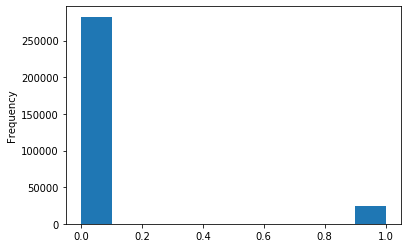

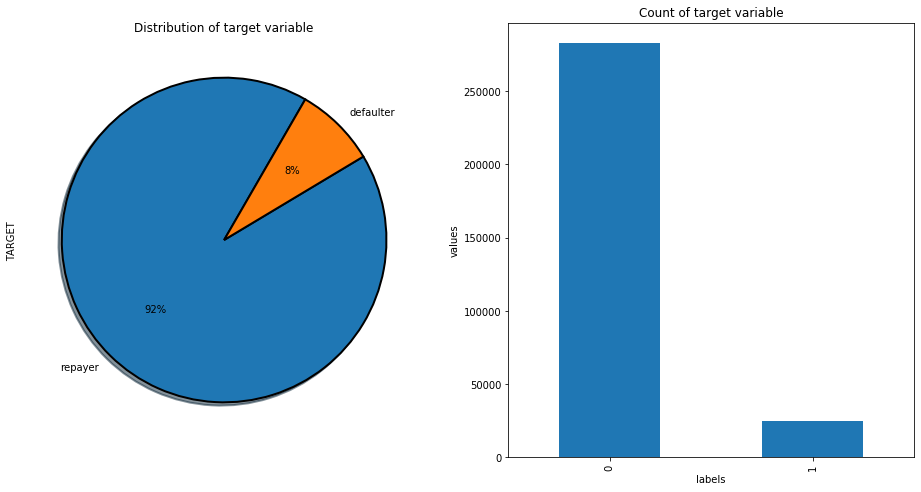

In [4]:
train_df['TARGET'].astype(int).plot.hist();

plt.figure(figsize=(16,8))
plt.subplot(121)
train_df["TARGET"].value_counts().plot.pie(autopct = "%1.0f%%",startangle = 60,labels=["repayer","defaulter"],
                                                                        wedgeprops={"linewidth":2,"edgecolor":"k"},shadow =True)
plt.title("Distribution of target variable")
plt.subplot(122)
train_df["TARGET"].value_counts().plot(kind="bar")
plt.title("Count of target variable")
plt.xlabel('labels')
plt.ylabel('values')

Text(0, 0.5, 'Number of clients')

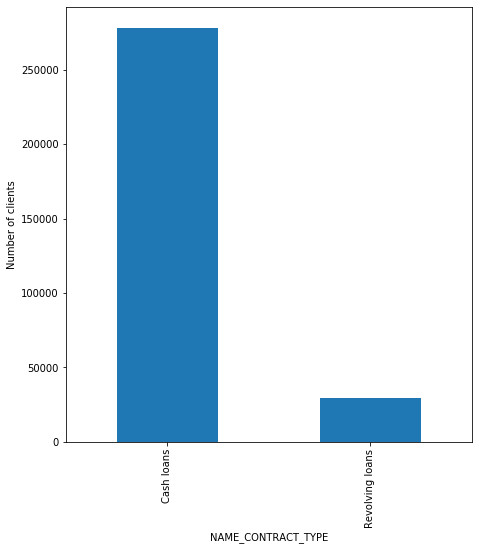

In [5]:
plt.figure(figsize=(16,8))
plt.subplot(121)
train_df["NAME_CONTRACT_TYPE"].value_counts().plot(kind="bar")
#sns.barplot(x=train_df["NAME_CONTRACT_TYPE"].value_counts().index, y=train_df["NAME_CONTRACT_TYPE"].value_counts().values, palette= 'muted')
                                         

plt.xlabel('NAME_CONTRACT_TYPE')
plt.ylabel('Number of clients')


#plt.subplot(122)

#plt.title("Count of target variable")
#plt.xlabel('labels')
#plt.ylabel('values')

## Column Types

Let's look at the number of columns of each data type. `int64` and `float64` are numeric variables ([which can be either discrete or continuous](https://stats.stackexchange.com/questions/206/what-is-the-difference-between-discrete-data-and-continuous-data)). `object` columns contain strings and are  [categorical features.](http://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/what-are-categorical-discrete-and-continuous-variables/) . 

In [6]:
# Number of each type of column
train_df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [7]:
# Number of unique classes in each object column
train_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

## Anomalies

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


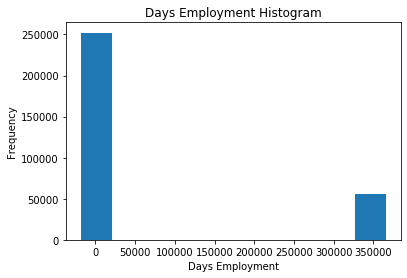

In [5]:
train_df['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

anom = train_df[train_df['DAYS_EMPLOYED'] == 365243]
anom['DAYS_EMPLOYED']

non_anom = train_df[train_df['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

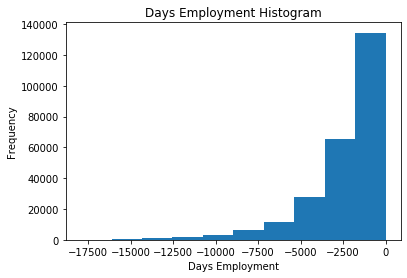

In [6]:
# Create an anomalous flag column
train_df['DAYS_EMPLOYED_ANOM'] = train_df["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
train_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

train_df['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

In [7]:
test_df['DAYS_EMPLOYED_ANOM'] = (test_df["DAYS_EMPLOYED"] == 365243)
test_df["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (test_df["DAYS_EMPLOYED_ANOM"].sum(), len(test_df)))

There are 9274 anomalies in the test data out of 48744 entries


### Concatenate train and test data

In [99]:
# we firstly concatenate the train and test data in the same dataframe
ntrain = train_df.shape[0]
print(train_df.shape)
ntest = test_df.shape[0]
print(test_df.shape)
y_train = train_df.TARGET.values
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['TARGET'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

(307511, 123)
(48744, 122)
all_data size is : (356255, 122)


### Handling missing data for both training data and testing data

In [9]:
# count NaN in categorical columns and sort them in descending order
total = all_data.select_dtypes('object').isnull().sum().sort_values(ascending=False)
percent = total/all_data.shape[0]
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(35)

Total   Percent
FONDKAPREMONT_MODE          243092  0.682354
WALLSMATERIAL_MODE          180234  0.505913
HOUSETYPE_MODE              177916  0.499406
EMERGENCYSTATE_MODE         167964  0.471471
OCCUPATION_TYPE             111996  0.314370
NAME_TYPE_SUITE               2203  0.006184
WEEKDAY_APPR_PROCESS_START       0  0.000000
ORGANIZATION_TYPE                0  0.000000
NAME_INCOME_TYPE                 0  0.000000
NAME_HOUSING_TYPE                0  0.000000
NAME_FAMILY_STATUS               0  0.000000
NAME_EDUCATION_TYPE              0  0.000000
NAME_CONTRACT_TYPE               0  0.000000
FLAG_OWN_REALTY                  0  0.000000
FLAG_OWN_CAR                     0  0.000000
CODE_GENDER                      0  0.000000

In [10]:
# 'FONDKAPREMONT_MODE' not knowing its meaning and not highlt correlated => drop
all_data = all_data.drop(columns = 'FONDKAPREMONT_MODE')

# WALLSMATERIAL_MODE, HOUSETYPE_MODE: according to FLAG_OWN_REALTY, assign "None" and mode to suitable cases respectively
for col in ('WALLSMATERIAL_MODE', 'HOUSETYPE_MODE'):
    all_data.loc[all_data['FLAG_OWN_REALTY'] == 'N',col] = all_data.loc[all_data['FLAG_OWN_REALTY'] == 'N',col].fillna('None')
    all_data.loc[all_data['FLAG_OWN_REALTY'] == 'Y',col] = all_data.loc[all_data['FLAG_OWN_REALTY'] == 'Y',col].fillna(all_data[col].mode()[0])

# EMERGENCYSTATE_MODE: Fill in with most frequent 
all_data['EMERGENCYSTATE_MODE'] = all_data['EMERGENCYSTATE_MODE'].fillna(all_data['EMERGENCYSTATE_MODE'].mode()[0])

# OCCUPATION_TYPE: according to NAME_INCOME_TYPE, assign "Unemployed" and mode "Laborers" to suitable cases respectively
for col in ('Pensioner', 'Unemployed', 'Student'):
    all_data.loc[all_data['NAME_INCOME_TYPE'] == col,'OCCUPATION_TYPE'] = all_data.loc[all_data['NAME_INCOME_TYPE'] == col,'OCCUPATION_TYPE'].fillna('Unemployed')
for col in ('Working', 'Commercial associate', 'State servant', 'Businessman', 'Maternity leave'):
    all_data.loc[all_data['NAME_INCOME_TYPE'] == col,'OCCUPATION_TYPE'] = all_data.loc[all_data['NAME_INCOME_TYPE'] == col,'OCCUPATION_TYPE'].fillna('Laborers')


# NAME_TYPE_SUITE: Fill in with most frequent which is "Unaccompanied"
all_data['NAME_TYPE_SUITE'] = all_data['NAME_TYPE_SUITE'].fillna('Unaccompanied') 
#all_data['NAME_TYPE_SUITE'].value_counts()


    


In [11]:
# count NaN in each numeric columns and sort them in descending order
# No NaN in 'int64'-type columns
total = all_data.select_dtypes('float64').isnull().sum().sort_values(ascending=False)
percent = total/all_data.shape[0]
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(35)

Total   Percent
COMMONAREA_AVG            248360  0.697141
COMMONAREA_MEDI           248360  0.697141
COMMONAREA_MODE           248360  0.697141
NONLIVINGAPARTMENTS_MODE  246861  0.692933
NONLIVINGAPARTMENTS_AVG   246861  0.692933
NONLIVINGAPARTMENTS_MEDI  246861  0.692933
LIVINGAPARTMENTS_AVG      242979  0.682037
LIVINGAPARTMENTS_MEDI     242979  0.682037
LIVINGAPARTMENTS_MODE     242979  0.682037
FLOORSMIN_AVG             241108  0.676785
FLOORSMIN_MEDI            241108  0.676785
FLOORSMIN_MODE            241108  0.676785
YEARS_BUILD_MEDI          236306  0.663306
YEARS_BUILD_MODE          236306  0.663306
YEARS_BUILD_AVG           236306  0.663306
OWN_CAR_AGE               235241  0.660316
LANDAREA_MEDI             210844  0.591835
LANDAREA_AVG              210844  0.591835
LANDAREA_MODE             210844  0.591835
BASEMENTAREA_MODE         207584  0.582684
BASEMENTAREA_AVG          207584  0.582684
BASEMENTAREA_MEDI         207584  0.582684
NONLIVINGAREA_AVG         195766  0.549511
NONLIVINGAREA_MODE        195766  0.549511
NONLIVINGAREA_MEDI        195766  0.549511
EXT_SOURCE_1              193910  0.544301
ELEVATORS_AVG             189080  0.530743
ELEVATORS_MEDI            189080  0.530743
ELEVATORS_MODE            189080  0.530743
APARTMENTS_MODE           179948  0.505110
APARTMENTS_MEDI           179948  0.505110
APARTMENTS_AVG            179948  0.505110
ENTRANCES_AVG             178407  0.500785
ENTRANCES_MEDI            178407  0.500785
ENTRANCES_MODE            178407  0.500785

In [12]:
numeric_NA = missing_data.index[missing_data['Percent'] > 0]

for col in numeric_NA:
    all_data[col] = all_data[col].fillna(all_data[col].median())

## Dimensonality Reduction - Primary Component Analysis - PCA

In [13]:
# Spliting the new_train into features X and target Y components
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
numeric_data = all_data[numeric_feats]
print(numeric_data.shape)
numeric_data


(356255, 106)


AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
0           24700.5    406597.5         351000.0          202500.0   
1           35698.5   1293502.5        1129500.0          270000.0   
2            6750.0    135000.0         135000.0           67500.0   
3           29686.5    312682.5         297000.0          135000.0   
4           21865.5    513000.0         513000.0          121500.0   
...             ...         ...              ...               ...   
356250      17473.5    412560.0         270000.0          121500.0   
356251      31909.5    622413.0         495000.0          157500.0   
356252      33205.5    315000.0         315000.0          202500.0   
356253      25128.0    450000.0         450000.0          225000.0   
356254      24709.5    312768.0         270000.0          135000.0   

        AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
0                             0.0                         0.0   
1                             0.0                         0.0   
2                             0.0                         0.0   
3                             0.0                         0.0   
4                             0.0                         0.0   
...                           ...                         ...   
356250                        0.0                         0.0   
356251                        0.0                         0.0   
356252                        0.0                         0.0   
356253                        0.0                         0.0   
356254                        0.0                         0.0   

        AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                             0.0                        0.0   
1                             0.0                        0.0   
2                             0.0                        0.0   
3                             0.0                        0.0   
4                             0.0                        0.0   
...                           ...                        ...   
356250                        0.0                        0.0   
356251                        0.0                        0.0   
356252                        0.0                        3.0   
356253                        0.0                        0.0   
356254                        0.0                        1.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_YEAR  ...  \
0                              0.0                         1.0  ...   
1                              0.0                         0.0  ...   
2                              0.0                         0.0  ...   
3                              0.0                         1.0  ...   
4                              0.0                         0.0  ...   
...                            ...                         ...  ...   
356250                         0.0                         1.0  ...   
356251                         0.0                         1.0  ...   
356252                         0.0                         1.0  ...   
356253                         0.0                         2.0  ...   
356254                         0.0                         4.0  ...   

        REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  SK_ID_CURR  \
0                                0                           0      100002   
1                                0                           0      100003   
2                                0                           0      100004   
3                                0                           0      100006   
4                                0                           0      100007   
...                            ...                         ...         ...   
356250                           0                           0      456221   
356251                           0                           0      456222   
356252                           0                           0

In [14]:
# Standardizing all the features to a normal distribution 
sc = StandardScaler()
numeric_data_std = sc.fit_transform(numeric_data)

In [15]:
# Using PCA from silkit learn
pca = PCA()
numeric_data_pca = pca.fit_transform(numeric_data_std)
numeric_data_pca.shape

(356255, 106)

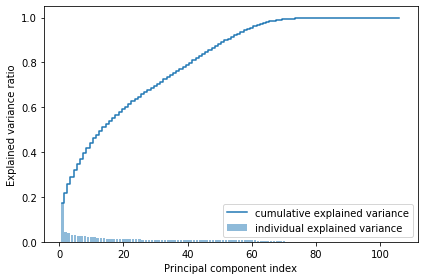

In [16]:
# Ploting the individual and cumulative explained variance of the features
plt.bar(range(1, (len(pca.explained_variance_ratio_) +1)), pca.explained_variance_ratio_, alpha=0.5, align='center', 
        label='individual explained variance')
plt.step(range(1, (len(pca.explained_variance_ratio_) +1)), np.cumsum(pca.explained_variance_ratio_), where='mid', 
        label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

(356255, 40)


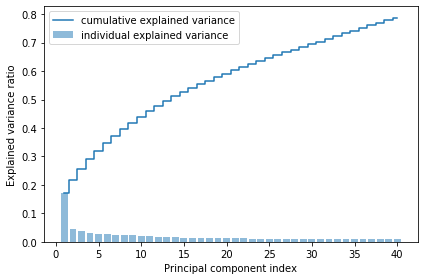

In [17]:
# Ploting the result of the cumulative variance with 40 features
pca = PCA(n_components= 40)
numeric_data_pca = pca.fit_transform(numeric_data_std)
print(numeric_data_pca.shape)
# Ploting the individual and cumulative explained variance of the features
plt.bar(range(1, 41), pca.explained_variance_ratio_, alpha=0.5, align='center', 
        label='individual explained variance')
plt.step(range(1, 41), np.cumsum(pca.explained_variance_ratio_), where='mid', 
        label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [18]:
pca = PCA(n_components=40)
columns = ['pca_comp_%i' % i for i in range(40)]
df_pca  = pd.DataFrame(pca.fit_transform(numeric_data_std), columns=columns, index=numeric_data.index)
print(df_pca.shape)



(356255, 40)


Text(0.5, 1, 'Correlation Heatmap')

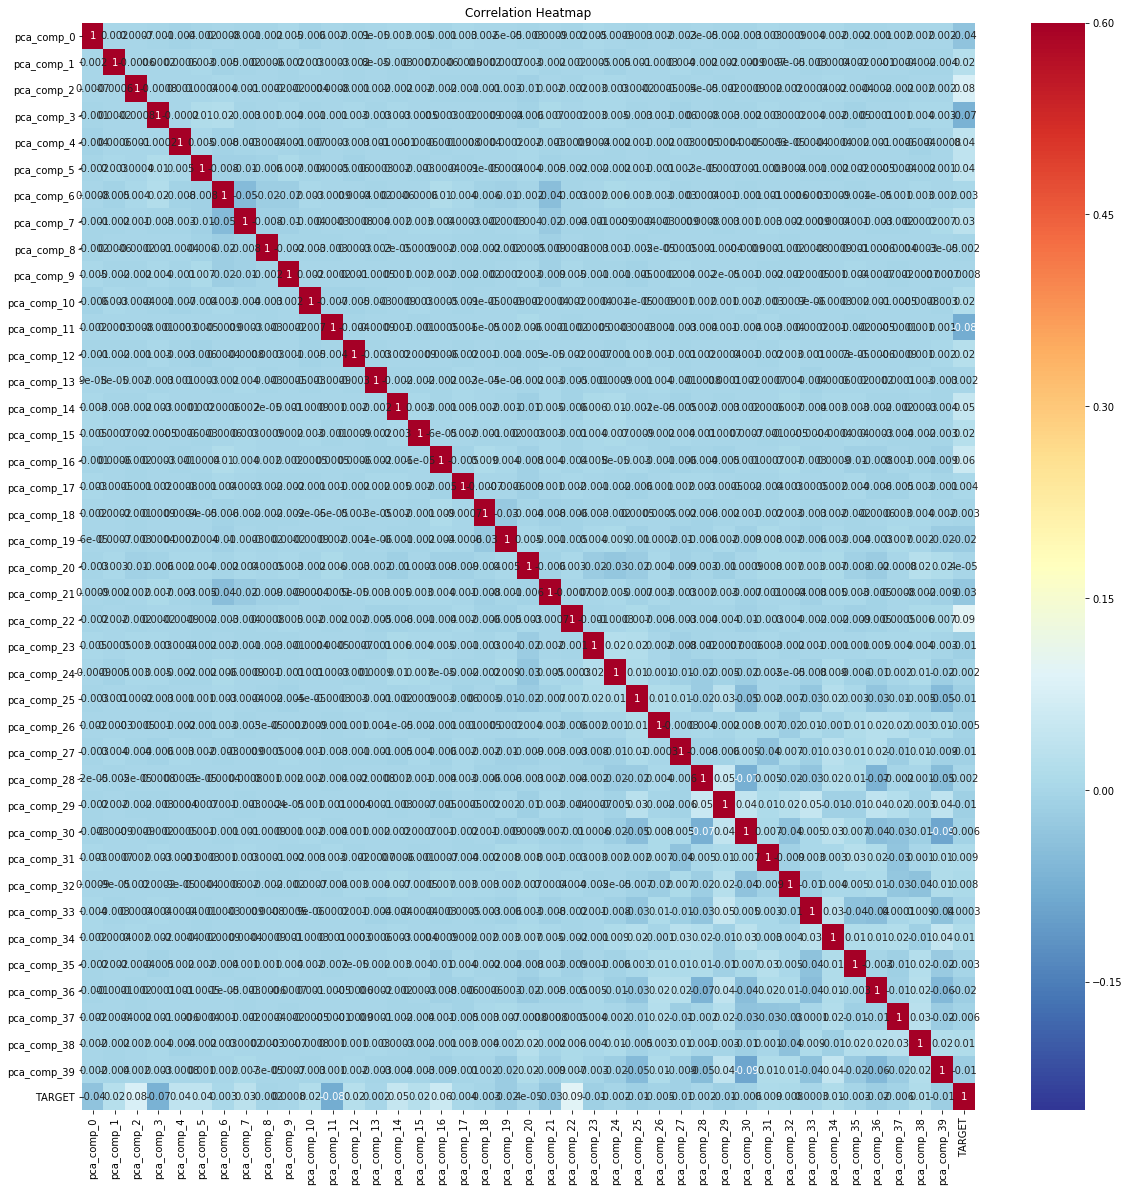

In [19]:
train_pca = df_pca[:ntrain]

train_pca['TARGET'] = y_train

cormat = train_pca.corr()
cormat
plt.figure(figsize = (20, 20))

# Heatmap of correlations
sns.heatmap(cormat, cmap = plt.cm.RdYlBu_r, vmin = -0.25,fmt='.0g', annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')


In [20]:
new_data = pd.concat([all_data, df_pca], axis=1)
print(new_data.shape)
new_data

(356255, 161)


AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
0           24700.5    406597.5         351000.0          202500.0   
1           35698.5   1293502.5        1129500.0          270000.0   
2            6750.0    135000.0         135000.0           67500.0   
3           29686.5    312682.5         297000.0          135000.0   
4           21865.5    513000.0         513000.0          121500.0   
...             ...         ...              ...               ...   
356250      17473.5    412560.0         270000.0          121500.0   
356251      31909.5    622413.0         495000.0          157500.0   
356252      33205.5    315000.0         315000.0          202500.0   
356253      25128.0    450000.0         450000.0          225000.0   
356254      24709.5    312768.0         270000.0          135000.0   

        AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
0                             0.0                         0.0   
1                             0.0                         0.0   
2                             0.0                         0.0   
3                             0.0                         0.0   
4                             0.0                         0.0   
...                           ...                         ...   
356250                        0.0                         0.0   
356251                        0.0                         0.0   
356252                        0.0                         0.0   
356253                        0.0                         0.0   
356254                        0.0                         0.0   

        AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                             0.0                        0.0   
1                             0.0                        0.0   
2                             0.0                        0.0   
3                             0.0                        0.0   
4                             0.0                        0.0   
...                           ...                        ...   
356250                        0.0                        0.0   
356251                        0.0                        0.0   
356252                        0.0                        3.0   
356253                        0.0                        0.0   
356254                        0.0                        1.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_YEAR  ...  \
0                              0.0                         1.0  ...   
1                              0.0                         0.0  ...   
2                              0.0                         0.0  ...   
3                              0.0                         1.0  ...   
4                              0.0                         0.0  ...   
...                            ...                         ...  ...   
356250                         0.0                         1.0  ...   
356251                         0.0                         1.0  ...   
356252                         0.0                         1.0  ...   
356253                         0.0                         2.0  ...   
356254                         0.0                         4.0  ...   

        pca_comp_30  pca_comp_31  pca_comp_32  pca_comp_33  pca_comp_34  \
0         -0.282232     0.122293    -0.610688    -0.553742     0.588536   
1         -0.082143    -0.389644    -0.658773    -0.827390     0.469646   
2          0.016718    -0.469272    -0.443090    -0.118766     0.308663   
3          0.184779    -0.375588    -0.902975    -0.919043     0.228784   
4          0.100555    -0.441471    -0.711212    -0.679637     0.176236   
...             ...          ...          ...          ...          ...   
356250     0.854464    -0.614215    -0.211958    -0.754328    -0.205208   
356251    -0.053901     0.234998     0.630537     0.508751    -0.409119   
356252     0.783108    -0.280933     1.023866     0.123599    -0.915249   
356253    -0.2

## Label Encoding Categorical Variables 

In [21]:
#convert categorical variable into dummy
new_data = pd.get_dummies(new_data)

In [22]:
new_data.shape

(356255, 285)

## Get the new train and test set

In [23]:
new_train = new_data[:ntrain]
new_test = new_data[ntrain:]

In [24]:
print(new_train.shape)
print(new_test.shape)

(307511, 285)
(48744, 285)


# Modeling

## Baseline: Logistic regression with all variables

In [34]:
regr = skl_lm.LogisticRegression()
regr.fit(new_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
pred_p = regr.predict_proba(new_train)
cm_df = pd.DataFrame({'True': y_train, 'Pred': pred_p[:,1] > .25})
cm_df.Pred.replace(to_replace={True:'Yes', False:'No'}, inplace=True)
print(cm_df.groupby(['True', 'Pred']).size().unstack('True').T)
print(classification_report(y_train, pred_p[:,1] > .25))

Pred      No  Yes
True             
0     281881  805
1      24618  207
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    282686
           1       0.20      0.01      0.02     24825

    accuracy                           0.92    307511
   macro avg       0.56      0.50      0.49    307511
weighted avg       0.86      0.92      0.88    307511



In [100]:
regr = skl_lm.LogisticRegression()
crossval_scores = cross_val_score(regr, new_train, y_train, scoring='roc_auc', cv=5)

In [101]:
print(crossval_scores)

[0.63444763 0.63207105 0.62509677 0.63354601 0.63781523 0.63189847
 0.63320888 0.62938718 0.63690855 0.63685232]


## Imporved v1: Logistic Regression with filtered variables

In [37]:
new_train_tar = new_train
new_train_tar['TARGET'] = y_train
print(new_train_tar)
new_train_tar

        AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
0           24700.5    406597.5         351000.0          202500.0   
1           35698.5   1293502.5        1129500.0          270000.0   
2            6750.0    135000.0         135000.0           67500.0   
3           29686.5    312682.5         297000.0          135000.0   
4           21865.5    513000.0         513000.0          121500.0   
...             ...         ...              ...               ...   
307506      27558.0    254700.0         225000.0          157500.0   
307507      12001.5    269550.0         225000.0           72000.0   
307508      29979.0    677664.0         585000.0          153000.0   
307509      20205.0    370107.0         319500.0          171000.0   
307510      49117.5    675000.0         675000.0          157500.0   

        AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
0                             0.0                         0.0   
1                            

AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
0           24700.5    406597.5         351000.0          202500.0   
1           35698.5   1293502.5        1129500.0          270000.0   
2            6750.0    135000.0         135000.0           67500.0   
3           29686.5    312682.5         297000.0          135000.0   
4           21865.5    513000.0         513000.0          121500.0   
...             ...         ...              ...               ...   
307506      27558.0    254700.0         225000.0          157500.0   
307507      12001.5    269550.0         225000.0           72000.0   
307508      29979.0    677664.0         585000.0          153000.0   
307509      20205.0    370107.0         319500.0          171000.0   
307510      49117.5    675000.0         675000.0          157500.0   

        AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
0                             0.0                         0.0   
1                             0.0                         0.0   
2                             0.0                         0.0   
3                             0.0                         0.0   
4                             0.0                         0.0   
...                           ...                         ...   
307506                        0.0                         0.0   
307507                        0.0                         0.0   
307508                        0.0                         1.0   
307509                        0.0                         0.0   
307510                        0.0                         0.0   

        AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                             0.0                        0.0   
1                             0.0                        0.0   
2                             0.0                        0.0   
3                             0.0                        0.0   
4                             0.0                        0.0   
...                           ...                        ...   
307506                        0.0                        0.0   
307507                        0.0                        0.0   
307508                        1.0                        0.0   
307509                        0.0                        0.0   
307510                        2.0                        0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_YEAR  ...  \
0                              0.0                         1.0  ...   
1                              0.0                         0.0  ...   
2                              0.0                         0.0  ...   
3                              0.0                         1.0  ...   
4                              0.0                         0.0  ...   
...                            ...                         ...  ...   
307506                         0.0                         1.0  ...   
307507                         0.0                         1.0  ...   
307508                         0.0                         1.0  ...   
307509                         0.0                         0.0  ...   
307510                         0.0                         1.0  ...   

        WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  \
0                                     1                          0   
1                                     0                          0   
2                                     0                          0   
3                                     0                          0   
4                                     0                          0   
...                                 ...                        ...   
307506                                1                          0   
307507                                1                          0   
307508                                0                          0   
307509                                1                         

In [38]:
#correlation matrix of all numerical variable
tar_cor = new_train_tar.corr()["TARGET"].sort_values()

# Display correlations
print('Most Positive Correlations:\n', tar_cor.tail(15))
print('\nMost Negative Correlations:\n', tar_cor.head(15))


Most Positive Correlations:
 pca_comp_14                                          0.046031
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
pca_comp_16                                          0.057883
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.063515
DAYS_BIRTH                                           0.078239
pca_comp_2                                           0.078592
pca_comp_22                                          0.093818
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [39]:
cor_top20 = abs(tar_cor).sort_values(ascending  = False).head(21).index


cor_top20

cormat = new_train_tar[cor_top20].corr()
cormat

-0.044935     1.000000   
pca_comp_3                                          -0.111427    -0.000961   
DAYS_EMPLOYED                                        0.185038    -0.191124   
REGION_RATING_CLIENT_W_CITY                          0.008073    -0.411708   
REGION_RATING_CLIENT                                 0.009361    -0.420213   
pca_comp_16                                          0.076707     0.000452   
NAME_INCOME_TYPE_Working                             0.304568     0.053205   
NAME_EDUCATION_TYPE_Higher education                 0.115808    -0.005680   
DAYS_LAST_PHONE_CHANGE                               0.082940    -0.199909   
CODE_GENDER_M                                        0.148060    -0.056605   
CODE_GENDER_F                                       -0.148074     0.056581   
DAYS_ID_PUBLISH                                      0.272691    -0.052774   
REG_CITY_NOT_WORK_CITY                               0.242401    -0.122613   
NAME_EDUCATION_TYPE_Secondary / secondary special   -0.157389     0.015361   

                                                   pca_comp_3  DAYS_EMPLOYED  \
TARGET                                              -0.070274       0.063515   
EXT_SOURCE_2                                         0.320898      -0.085796   
EXT_SOURCE_3                                         0.056274      -0.088474   
EXT_SOURCE_1                                         0.178128      -0.132413   
pca_comp_22                                          0.000166       0.278005   
pca_comp_2                                          -0.000799       0.021506   
DAYS_BIRTH                                          -0.111427       0.185038   
pca_comp_11                                         -0.000961      -0.191124   
pca_comp_3                                           1.000000      -0.096077   
DAYS_EMPLOYED                                       -0.096077       1.000000   
REGION_RATING_CLIENT_W_CITY                         -0.523288      -0.003911   
REGION_RATING_CLIENT                                -0.522550      -0.005450   
pca_comp_16                                          0.000338       0.325021   
NAME_INCOME_TYPE_Working                            -0.103771      -0.047810   
NAME_EDUCATION_TYPE_Higher education                 0.111910      -0.010150   
DAYS_LAST_PHONE_CHANGE                              -0.117220       0.130030   
CODE_GENDER_M                                        0.009926       0.064499   
CODE_GENDER_F                                       -0.009919      -0.064475   
DAYS_ID_PUBLISH                                     -0.026638       0.045496   
REG_CITY_NOT_WORK_CITY                              -0.105429       0.090158   
NAME_EDUCATION_TYPE_Secondary / secondary special   -0.099352      -0.014606   

                                                   ...  REGION_RATING_CLIENT  \
TARGET                                             ...              0.058899   
EXT_SOURCE_2                                       ...             -0.292621   
EXT_SOURCE_3                                       ...             -0.011701   
EXT_SOURCE_1                                       ...             -0.078017   
pca_comp_22                                        ...             -0.001138   
pca_comp_2                                         ...             -0.021026   
DAYS_BIRTH                                         ...              0.009361   
pca_comp_11                                        ...             -0.420213   
pca_comp_3                                         ...             -0.522550   
DAYS_EMPLOYED                                      ...             -0.005450   
REGION_RATING_CLIENT_W_CITY                        ...              0.950842   
REGION_RATING_CLIENT                               ...              1.000000   
pca_comp_16                                        ...             -0.214226   
NAME_INCOME_TYPE_Working                           ...              0.102809  

Text(0.5, 1, 'Correlation Heatmap')

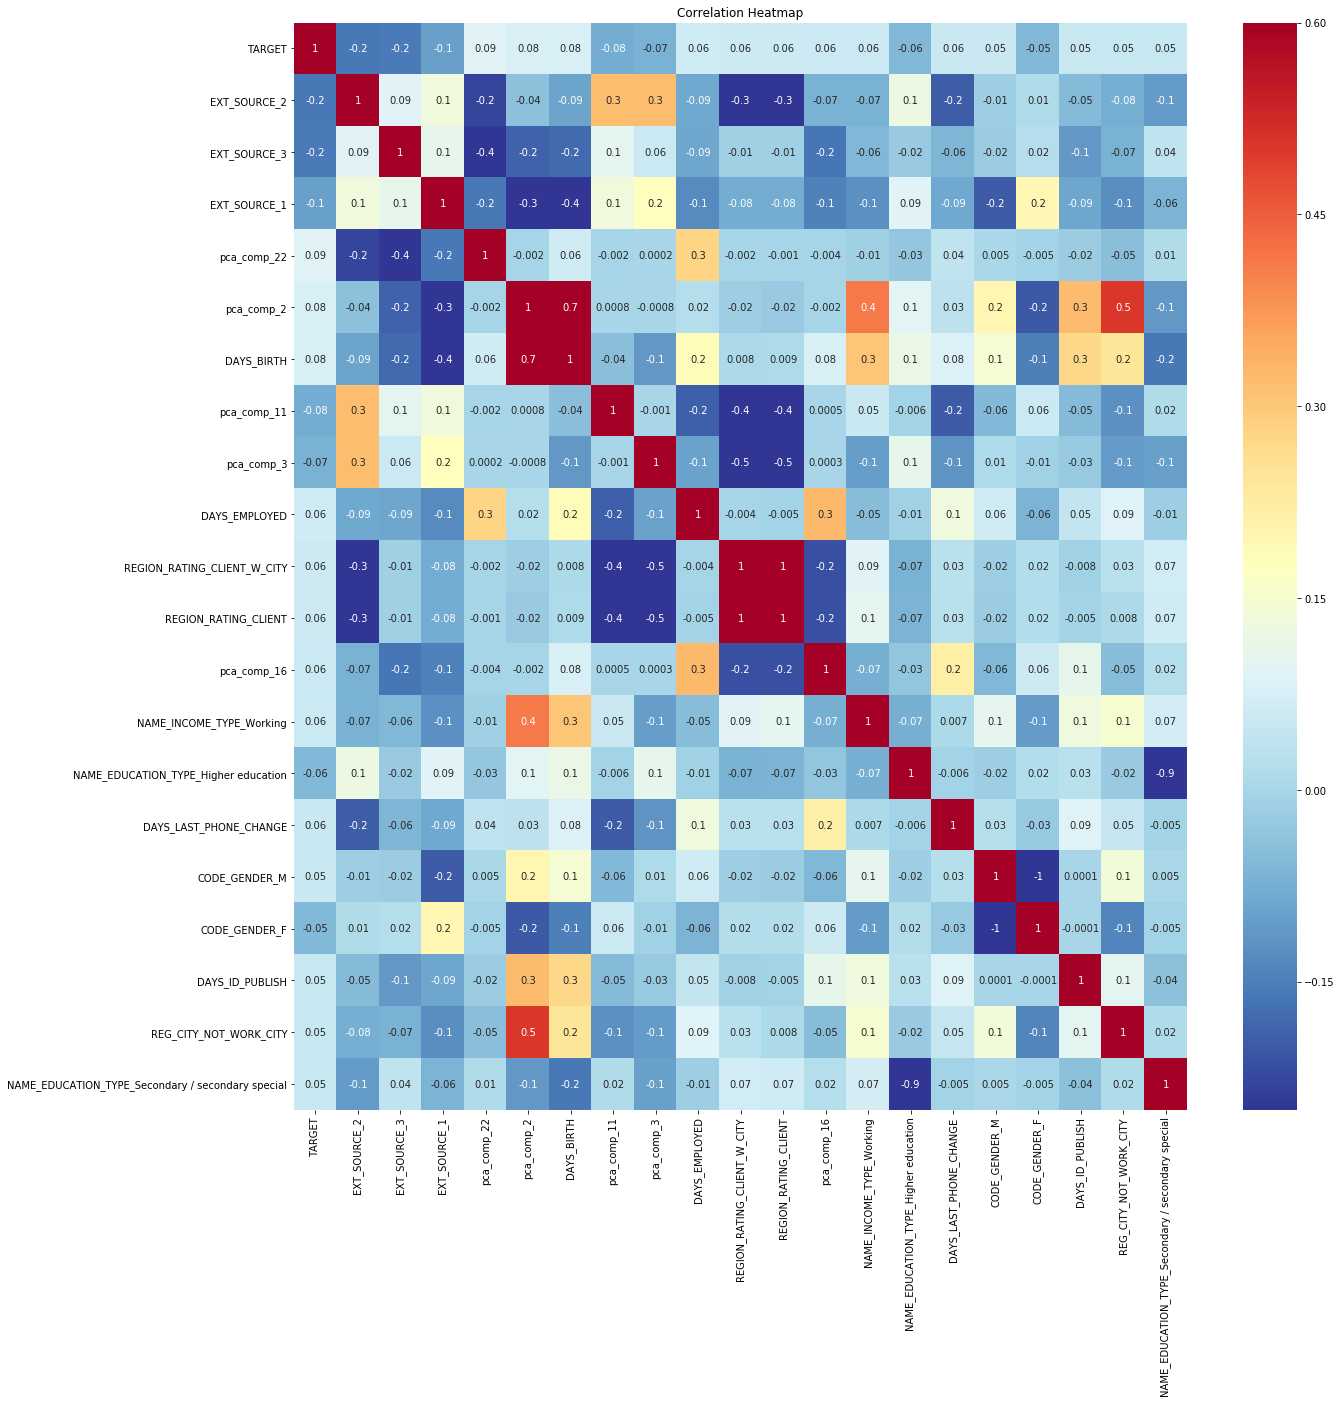

In [40]:
plt.figure(figsize = (20, 20))

# Heatmap of correlations
sns.heatmap(cormat, cmap = plt.cm.RdYlBu_r, vmin = -0.25,fmt='.0g', annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

### Remove multicolinearity
#### Remove variables who > 0.6 correlated with one or more other variables, keep the variables with higher rank

In [41]:
filtered_var = cor_top20
# 'pca_comp_2' and 'DAYS_BIRTH': 0.7
filtered_var = filtered_var.drop('DAYS_BIRTH')
# 'REGION_RATING_CLIENT_W_CITY' and 'REGION_RATING_CLIENT': 1
filtered_var = filtered_var.drop('REGION_RATING_CLIENT')
# 'CODE_GENDER_M' and 'CODE_GENDER_F': -1
filtered_var = filtered_var.drop('CODE_GENDER_F')
# 'NAME_EDUCATION_TYPE_Higher education' and 'NAME_EDUCATION_TYPE_Secondary/secondary special': -0.9
filtered_var = filtered_var.drop('NAME_EDUCATION_TYPE_Secondary / secondary special')

print(len(filtered_var))
filtered_var

17


Index(['TARGET', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_1', 'pca_comp_22',
       'pca_comp_2', 'pca_comp_11', 'pca_comp_3', 'DAYS_EMPLOYED',
       'REGION_RATING_CLIENT_W_CITY', 'pca_comp_16',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education',
       'DAYS_LAST_PHONE_CHANGE', 'CODE_GENDER_M', 'DAYS_ID_PUBLISH',
       'REG_CITY_NOT_WORK_CITY'],
      dtype='object')

Text(0.5, 1, 'Correlation Heatmap')

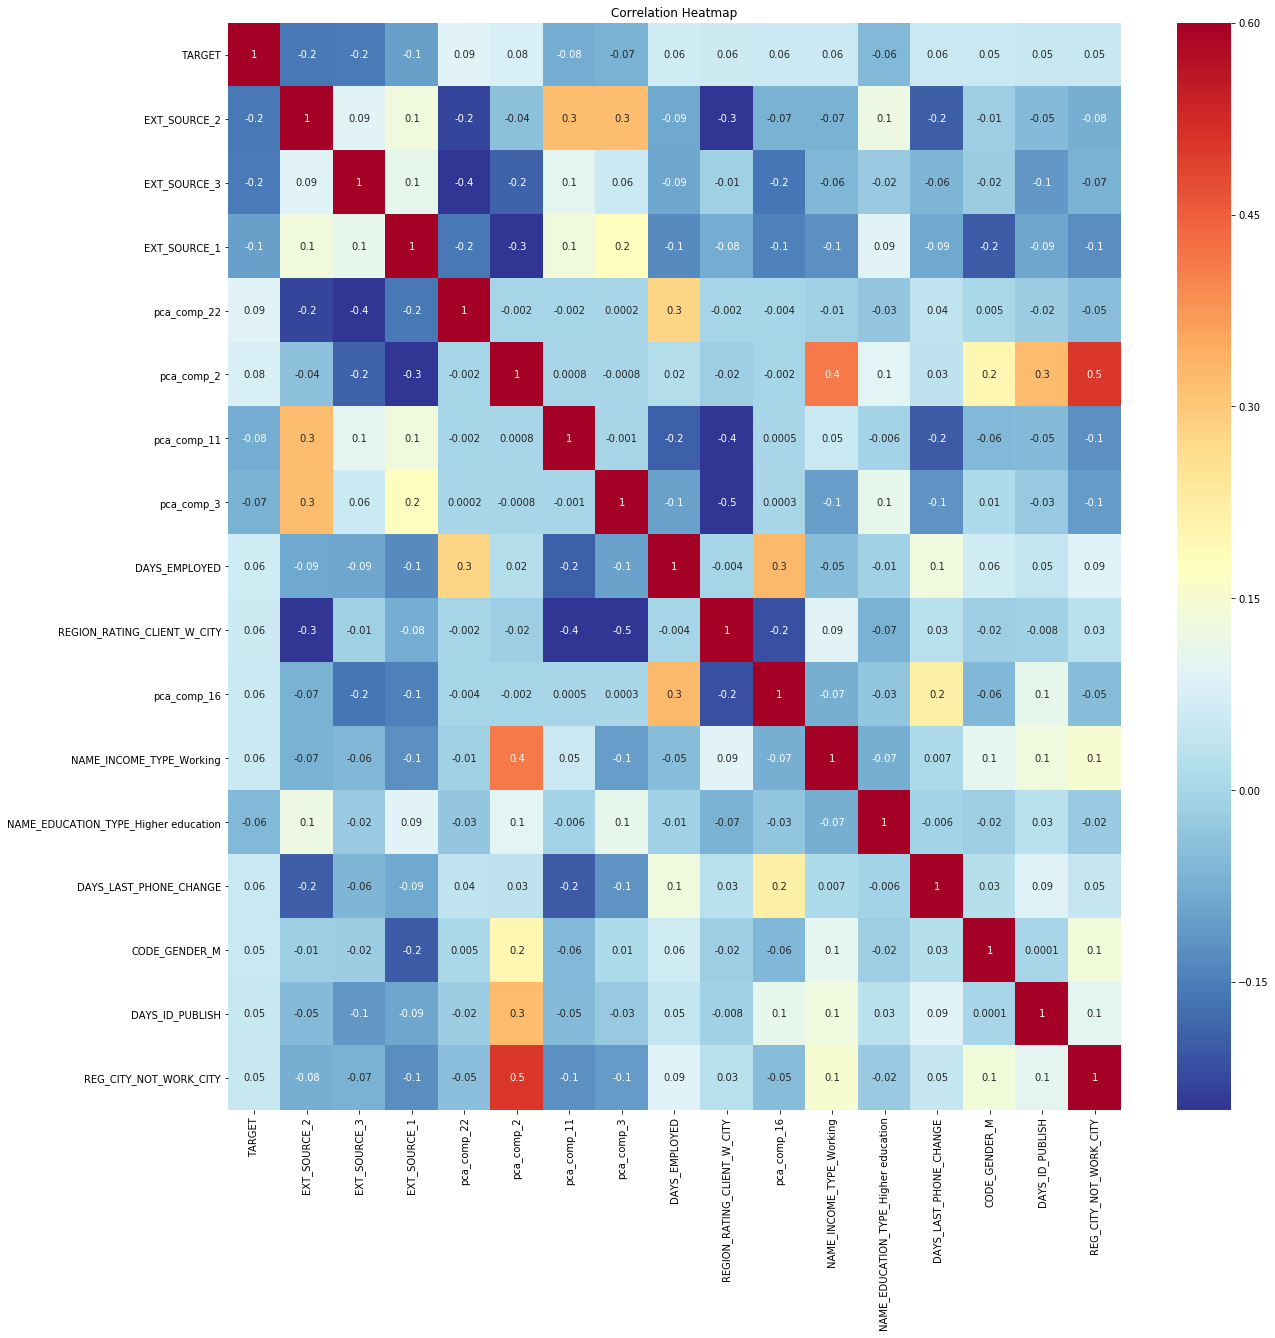

In [42]:
cormat = new_train_tar[filtered_var].corr()
plt.figure(figsize = (20, 20))

# Heatmap of correlations
sns.heatmap(cormat, cmap = plt.cm.RdYlBu_r, vmin = -0.25,fmt='.0g', annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

In [43]:
# train dataset with only filtered 16 predictors
filtered_train = new_train[filtered_var.drop('TARGET')]
print(filtered_train.shape)
filtered_train

(307511, 16)


EXT_SOURCE_2  EXT_SOURCE_3  EXT_SOURCE_1  pca_comp_22  pca_comp_2  \
0           0.262949      0.139376      0.083037     1.584107    0.817421   
1           0.622246      0.533482      0.311267     0.636935    0.332703   
2           0.555912      0.729567      0.506155    -0.226252   -0.730893   
3           0.650442      0.533482      0.506155    -1.113766   -0.395950   
4           0.322738      0.533482      0.506155    -1.030258    0.460571   
...              ...           ...           ...          ...         ...   
307506      0.681632      0.533482      0.145570    -0.399209   -0.132452   
307507      0.115992      0.533482      0.506155     1.398554   -3.050372   
307508      0.535722      0.218859      0.744026    -1.192903    1.156807   
307509      0.514163      0.661024      0.506155    -2.119959    1.539482   
307510      0.708569      0.113922      0.734460     2.045698    1.557401   

        pca_comp_11  pca_comp_3  DAYS_EMPLOYED  REGION_RATING_CLIENT_W_CITY  \
0         -1.237796    0.642361         -637.0                            2   
1          0.406880    0.904321        -1188.0                            1   
2          0.742573   -1.094337         -225.0                            2   
3          0.871259   -0.183359        -3039.0                            2   
4         -0.269085   -0.117127        -3038.0                            2   
...             ...         ...            ...                          ...   
307506    -0.453126    1.780358         -236.0                            1   
307507    -0.915382    0.960215        -1663.0                            2   
307508    -4.726031   -0.650201        -7921.0                            3   
307509     0.205033   -1.198819        -4786.0                            2   
307510     1.398939    2.415777        -1262.0                            1   

        pca_comp_16  NAME_INCOME_TYPE_Working  \
0          0.636045                         1   
1          0.800719                         0   
2         -2.039829                         1   
3          0.465803                         1   
4         -1.628152                         1   
...             ...                       ...   
307506    -0.069628                         1   
307507     0.291019                         0   
307508    -1.671640                         1   
307509     0.718299                         0   
307510    -0.507471                         0   

        NAME_EDUCATION_TYPE_Higher education  DAYS_LAST_PHONE_CHANGE  \
0                                          0                 -1134.0   
1                                          1                  -828.0   
2                                          0                  -815.0   
3                                          0                  -617.0   
4                                          0                 -1106.0   
...                                      ...                     ...   
307506                                     0                  -273.0   
307507                                     0                     0.0   
307508                                     1                 -1909.0   
307509                                     0                  -322.0   
307510                                     1                  -787.0   

        CODE_GENDER_M  DAYS_ID_PUBLISH  REG_CITY_NOT_WORK_CITY  
0                   1            -2120                       0  
1                   0             -291                       0  
2                   1            -2531                       0  
3                   0            -2437                       0  
4                   1            -3458                       1  
...               ...              ...                     ...  
307506              1            -1982                       0  
307507              0            -4090                       0  
307508              0            -5150                       1  
307509              0         

In [59]:
# drop the 'TARGET' col from train table
new_train = new_train.drop(columns = 'TARGET')

In [60]:
# Train the model with filtered dataset
regr.fit(filtered_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [61]:
filt_pred_p = regr.predict_proba(filtered_train)
cm_df = pd.DataFrame({'True': y_train, 'Pred': filt_pred_p[:,1] > .25})
cm_df.Pred.replace(to_replace={True:'Yes', False:'No'}, inplace=True)
print(cm_df.groupby(['True', 'Pred']).size().unstack('True').T)
print(classification_report(y_train, filt_pred_p[:,1] > .25))

Pred      No   Yes
True              
0     277905  4781
1      22617  2208
              precision    recall  f1-score   support

           0       0.92      0.98      0.95    282686
           1       0.32      0.09      0.14     24825

    accuracy                           0.91    307511
   macro avg       0.62      0.54      0.55    307511
weighted avg       0.88      0.91      0.89    307511



### Cross-validation of logistic regression

In [131]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5,shuffle=False)
regr = skl_lm.LogisticRegression()

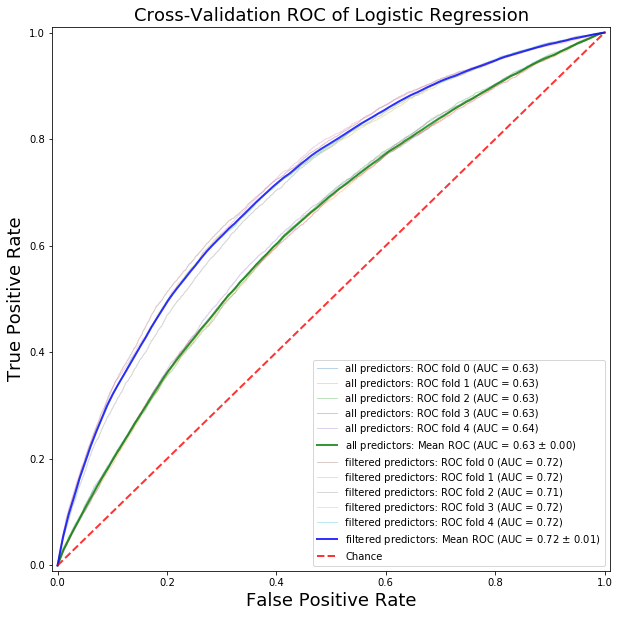

In [138]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(new_train, y_train):
    probas_ = regr.fit(new_train.loc[train], y_train[train]).predict_proba(new_train.loc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='all predictors: ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='g',
         label=r'all predictors: Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(filtered_train, y_train):
    probas_ = regr.fit(filtered_train.loc[train], y_train[train]).predict_proba(filtered_train.loc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='filtered predictors: ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1



mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'filtered predictors: Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)


plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Logistic Regression',fontsize=18)
plt.legend(loc="lower right", prop={'size': 10})
plt.show()

## Improved v2: Linear Discriminant Analysis with all variables

In [62]:
lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(new_train,y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [63]:
decision_prob = 0.2
y_prob = lda.predict_proba(new_train)

df_ = pd.DataFrame({'True default status': y_train,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status           No    Yes
Predicted default status               
No                        263843  17834
Yes                        18843   6991

In [64]:
def plot_confusion_matrix(cm, title='Confusion matrix (Normalized)',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized confusion matrix')
    plt.colorbar()
    plt.tight_layout()
    plt.xlabel('True label',rotation='horizontal', ha='right')
    plt.ylabel('Predicted label')
    plt.show()

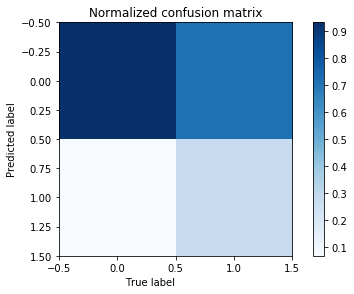

In [65]:
# Check confusion matrix 
cm = confusion_matrix(y_train, y_prob[:,1] > decision_prob)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized.T)

In [66]:
print(classification_report(y_train, y_prob[:,1] > decision_prob, target_names=['No', 'Yes'], digits=3))

              precision    recall  f1-score   support

          No      0.937     0.933     0.935    282686
         Yes      0.271     0.282     0.276     24825

    accuracy                          0.881    307511
   macro avg      0.604     0.607     0.606    307511
weighted avg      0.883     0.881     0.882    307511



### Cross-validation of LDA 

In [136]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5,shuffle=False)
lda = LinearDiscriminantAnalysis(solver='svd')

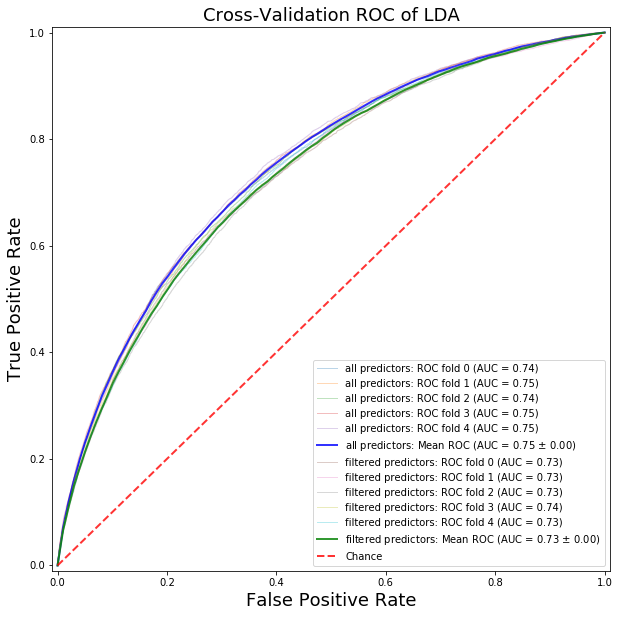

In [139]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(new_train, y_train):
    probas_ = lda.fit(new_train.loc[train], y_train[train]).predict_proba(new_train.loc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='all predictors: ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'all predictors: Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


i = 0
for train, test in cv.split(filtered_train, y_train):
    probas_ = lda.fit(filtered_train.loc[train], y_train[train]).predict_proba(filtered_train.loc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='filtered predictors: ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='g',
         label=r'filtered predictors: Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of LDA',fontsize=18)
plt.legend(loc="lower right", prop={'size': 10})
plt.show()

## Improved v3: Linear discriminant analysis with filtered predictors

In [67]:
lda.fit(filtered_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [68]:
decision_prob = 0.2
filt_y_prod = lda.predict_proba(filtered_train)



df_ = pd.DataFrame({'True default status': y_train,
                    'Predicted default status': filt_y_prod[:,1] > decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status           No    Yes
Predicted default status               
No                        265018  18674
Yes                        17668   6151

In [69]:
print(classification_report(y_train, y_prob[:,1] > decision_prob, target_names=['No', 'Yes'], digits=3))

              precision    recall  f1-score   support

          No      0.937     0.933     0.935    282686
         Yes      0.271     0.282     0.276     24825

    accuracy                          0.881    307511
   macro avg      0.604     0.607     0.606    307511
weighted avg      0.883     0.881     0.882    307511



## Improved v5: Random Forest

In [85]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 10, random_state = 50, verbose = 4, n_jobs = -1)

In [86]:
# Train on the training data
random_forest.fit(new_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
building tree 1 of 10building tree 2 of 10
building tree 3 of 10

building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   11.0s remaining:    7.4s
building tree 10 of 10
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.4s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=50, verbose=4,
                       warm_start=False)

In [87]:
decision_prob = 0.2

# Extract feature importances
features = list(new_train.columns)
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
rf_prod = random_forest.predict_proba(new_train)

df_ = pd.DataFrame({'True default status': y_train,
                    'Predicted default status': rf_prod[:,1] > decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.6s finished


True default status           No    Yes
Predicted default status               
No                        280357     81
Yes                         2329  24744

In [88]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

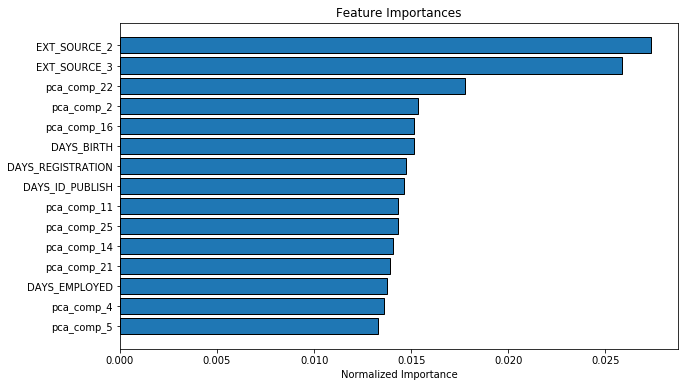

In [89]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

In [90]:
print(classification_report(y_train, rf_prod[:,1] > decision_prob, target_names=['No', 'Yes'], digits=3))

              precision    recall  f1-score   support

          No      1.000     0.992     0.996    282686
         Yes      0.914     0.997     0.954     24825

    accuracy                          0.992    307511
   macro avg      0.957     0.994     0.975    307511
weighted avg      0.993     0.992     0.992    307511



### Cross-validation of random forest

In [105]:
random_forest = RandomForestClassifier(n_estimators = 10, random_state = 50, verbose = 4, n_jobs = -1)
crossval_scores = cross_val_score(lda, new_train, y_train, scoring='roc_auc', cv=5)
print(crossval_scores)

[0.74351553 0.74509909 0.74169531 0.74793824 0.74941917]


In [141]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5,shuffle=False)
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 4, n_jobs = -1)

 17 tasks      | elapsed:   47.1s
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
buildi

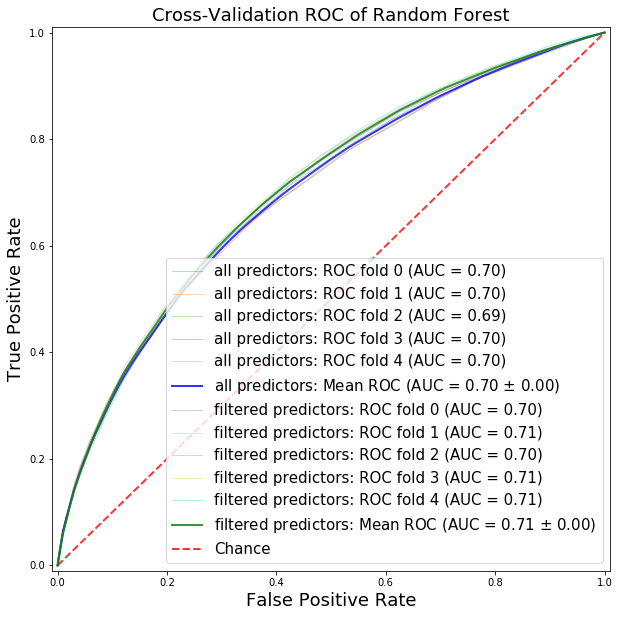

In [142]:

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(new_train, y_train):
    probas_ = random_forest.fit(new_train.loc[train], y_train[train]).predict_proba(new_train.loc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='all predictors: ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'all predictors: Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


i = 0
for train, test in cv.split(filtered_train, y_train):
    probas_ = random_forest.fit(filtered_train.loc[train], y_train[train]).predict_proba(filtered_train.loc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='filtered predictors: ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='g',
         label=r'filtered predictors: Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Random Forest',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

# Summary of model results

In [91]:
# ROC curve of Logistic Regression with all predictors
false_pos_rate1, true_pos_rate1, _ = roc_curve(y_train, pred_p[:,1])
roc_auc1 = auc(false_pos_rate1, true_pos_rate1)

# ROC curve of Logistic Regression with filtered predictors
false_pos_rate2, true_pos_rate2, _ = roc_curve(y_train, filt_pred_p[:,1])
roc_auc2 = auc(false_pos_rate2, true_pos_rate2)

# ROC curve of LDA with all predictors
false_pos_rate3, true_pos_rate3, _ = roc_curve(y_train, y_prob[:,1])
roc_auc3 = auc(false_pos_rate3, true_pos_rate3)

# ROC curve of LDA with filtered predictors
false_pos_rate4, true_pos_rate4, _ = roc_curve(y_train, filt_y_prod[:,1])
roc_auc4 = auc(false_pos_rate4, true_pos_rate4)

# ROC curve of Random Forest with all predictors
false_pos_rate5, true_pos_rate5, _ = roc_curve(y_train, rf_prod[:,1])
roc_auc5 = auc(false_pos_rate5, true_pos_rate5)



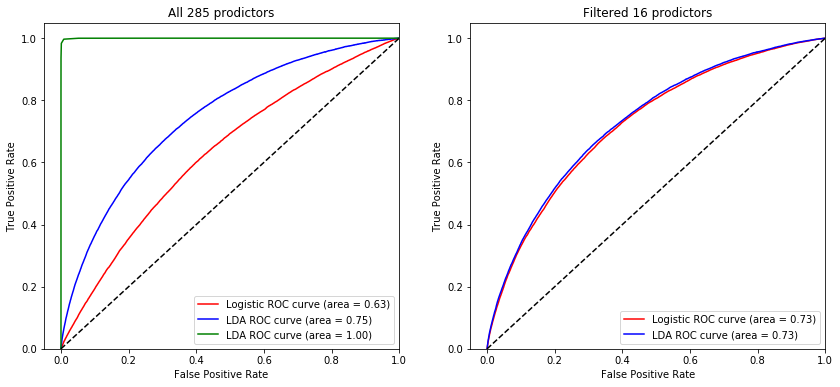

In [92]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.plot(false_pos_rate1, true_pos_rate1, label='Logistic ROC curve (area = %0.2f)' % roc_auc1, color='r')
ax1.plot(false_pos_rate3, true_pos_rate3, label='LDA ROC curve (area = %0.2f)' % roc_auc3, color='b')
ax1.plot(false_pos_rate5, true_pos_rate5, label='LDA ROC curve (area = %0.2f)' % roc_auc5, color='g')
ax1.set_title('All 285 prodictors')

ax2.plot(false_pos_rate2, true_pos_rate2, label='Logistic ROC curve (area = %0.2f)' % roc_auc2, color='r')
ax2.plot(false_pos_rate4, true_pos_rate4, label='LDA ROC curve (area = %0.2f)' % roc_auc4, color='b')
ax2.set_title('Filtered 16 prodictors')


for ax in fig.axes:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

In [75]:
# make prediction with LDA model
pred_test = lda.fit(new_train, y_train).predict_proba(new_test)[:,1]

In [76]:
# make submission
submit = test_df[['SK_ID_CURR']]
submit['TARGET'] = pred_test
submit.to_csv('submission1.csv', index = False)

In [72]:
# make prediction with LR model
filtered_test = new_test[filtered_var.drop('TARGET')]

pred_test = regr.fit(filtered_train, y_train).predict_proba(filtered_test)[:,1]

In [74]:
# make submission
submit = test_df[['SK_ID_CURR']]
submit['TARGET'] = pred_test
submit.to_csv('submission2.csv', index = False)

In [93]:
# make prediction with Random forest model
pred_test = random_forest.fit(new_train, y_train).predict_proba(new_test)[:,1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
building tree 1 of 10building tree 2 of 10

building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   11.9s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished


In [94]:
# make submission
submit = test_df[['SK_ID_CURR']]
submit['TARGET'] = pred_test
submit.to_csv('submission3.csv', index = False)